# Walk-through of a neural network using TensorFlow
-  by Gabriel Jurado

This notebook is intended to serve as an accessible example of how machine learning is used for data analysis. Details concerning the architecture of the TensorFlow package and a rigorous formulation of the mahcine learning theory are not discussed here. For information concerning TensorFlow and machine learning basics please refer to https://www.tensorflow.org/get_started/get_started_for_beginners and http://www.deeplearningbook.org/, respectively. 

The goal of a typical machine learning program is to learn a non-trivial representation of provided data, such that, the resulting representation showcases statistically relevant information between the unknown variables. 

Roughly speaking, the desired representation is learned by iteratively differentiating through a generalized function space, where the direction of each consecutive iteration is determined by the set of function parameters that minimize the difference between the values predicted by the model and the values taken from the data. Those familiar with optimization techniques will recognize this as gradient descent. It is important to note that for each iteration only a local minimum is found, only after many consecutive iterations called 'epochs', can we be confident in claiming to have found the global minimum. In this context, the global minimum represents the function that best models the empirical data whose function parameters were optimized by gradient descent. 

Once the neural network has been trained and the corresponding model learned, it can be given an entitrely new data set and immediately return the function that best represents the desired analytical model for the data, e.g., classification, regression, etc. 

## The data

The example below uses data representative of a typical data set used in financial analysis of the stock market. 

The code below simply imports the data file using a standard package manager such as numpy or pandas, saves and names each file as an array, and then checks the dimensions of the data. 

In [410]:
import numpy as np
import csv
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

pathx='/home/gabriel/miniconda3/data/task1_1_learn_X.csv'    
pathy='/home/gabriel/miniconda3/data/task1_1_learn_y.csv'
pathx_2='/home/gabriel/miniconda3/data/task1_1_test_X.csv'

with open(pathx, newline='') as csvfile:
    datax = csv.reader(csvfile, delimiter=' ', quoting = csv.QUOTE_NONNUMERIC)
    dataX_train = list(datax)
with open(pathx_2, newline='') as csvfile:
    datax2 = csv.reader(csvfile, delimiter=' ', quoting = csv.QUOTE_NONNUMERIC)
    dataX_test = list(datax2)
with open(pathy, newline='') as csvfile:
    datay = csv.reader(csvfile, delimiter=' ', quoting = csv.QUOTE_NONNUMERIC)
    dataY_train =np.ravel(list(datay))

    
X_data = np.array(dataX_train)
Y_data = np.array(dataY_train,dtype=np.int32)

X_test = np.array(dataX_test)

(X_data).shape


(1000, 20)

This particuar data set is a $ 1000 \times 20 $ matrix. The number of rows represent the number of measurements taken while the number of columns gives the number of unknown parameters our program needs to learn. 

In order to reach a more intuitive understanding of what the data looks like, let's go ahead and plot the distribution. 

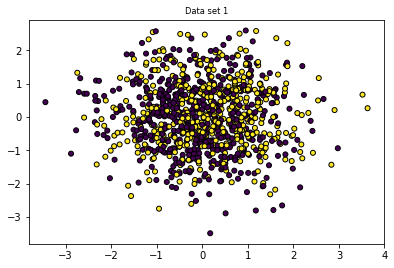

In [411]:
plt.figure(figsize=(14, 14))


plt.subplot(321)
plt.title("Data set 1", fontsize='small')
plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=Y_data,
            s=25, edgecolor='k')



As one can see, plotting the raw representation of the data provides no information about the statistical independence of the unknown variables, nor does it lead one to conclude the variables are related in a predicatable way. In fact, the distribution looks to be noise, i.e., a Gaussian distribution centered around zero. 

If one's task was to determine if the variables are statistically independent, i.e., seperable into classes of yellow and blue, or to determine the value of the next blue given only the value of the previous yellow, how would one proceed?

First, we must introduce the concept of principle component analysis or PCA. For the purposes of this notebook, we only need to know that PCA maps the high-dimensional data into a lower-dimensional subspace, by maximizing for the orthogonality of the unknown variables. In the lower dimensional space, the model for the data may have a more obvious representation. For those interested in PCA we refer https://arxiv.org/pdf/1404.1100.pdf. 

 Below is the same data reduced from 20 dimensions to 10 dimensions. 

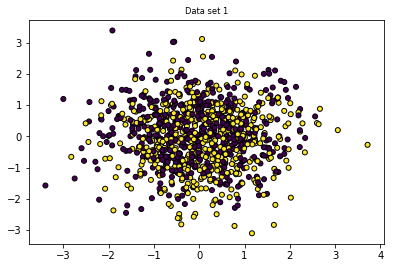

In [412]:
from sklearn.decomposition import PCA
pca = PCA(n_components=min(1000, 10), whiten=True, svd_solver='full', tol=0.0, iterated_power='auto', random_state=None)
X_data = pca.fit_transform(X_data)

plt.figure(figsize=(14, 14))


plt.subplot(322)
plt.title("Data set 1", fontsize='small')
plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=Y_data,
            s=25, edgecolor='k')


Although not indicative of completely seperable independent variables, there is progress, albeit miniscule. Let's try reducing the dimensions by half again and see what we get. 

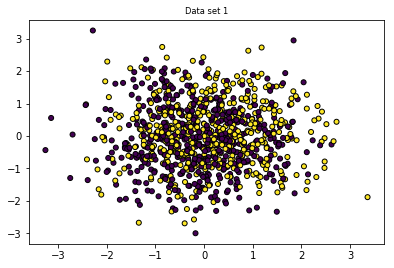

In [425]:
from sklearn.decomposition import PCA
pca = PCA(n_components=min(1000, 5), whiten=True, svd_solver='full', tol=0.0, iterated_power='auto', random_state=None)
X_data = pca.fit_transform(X_data)

plt.figure(figsize=(14, 14))


plt.subplot(322)
plt.title("Data set 1", fontsize='small')
plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=Y_data,
            s=25, edgecolor='k')


Only slightly better. This is a fairly strong indication that the data provided is most likely not linearly seperable in its current form. Recall the original size of the data, a $1000 \times 20$ matrix. This is equivalent to having 1000 measurements of a function with unknown power-law and 20 unknown parameters. This is in general, even for the most rigorous algorithms, a very difficult problem. 

Now that we have encountered our first example of why data analysis can be difficult, let's take a step back and see how the field of machine learning has grown to attend this issue.

## Learning Goal

We will explore how our ability to predict depends on the number of data points we have, the "noise" in the data, and our knowledge about relevant features. The goal is to build intuition about why prediction is difficult and discuss general strategies for overcoming these difficulties.

## Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation
$$
    y_i= f(x_i) + \eta_i,
$$
where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that
$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$
We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make prediction, we will consider a family of functions $g_\alpha(x;\theta_\alpha)$ that depend on some parameters $\theta_\alpha$. These functions respresent the **model class** that we are using to try to model the data and make predictions. The $g_\alpha(x;\theta_\alpha)$ encode the class of **features** we are using to represent the data.

To learn the parameters $\boldsymbol{\theta}$, we will train our models on a **training data set** and then test the effectiveness of model on a <i>different</i> dataset, the **test data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen. As we will see below, models that give the best fit to the training data do not necessarily make the best predictions on the test data. This will be a running theme that we will encounter repeatedly in machine learning.  


For the remainder of this example, we will focus on polynomial regression. Our task is to model the data with polynomials and make predictions about the new data that we have not seen.
We will consider two qualitatively distinct situations. 
<ul>
<li> In the first case, the process that generates the underlying data is in the model class we are using to make predictions. For polynomial regression, this means that the functions $f(x_i)$ are themselves polynomials.
<li>In the second case, our data lies outside our model class. In the case of polynomial regression, this could correspond to the case where the $f(x_i)$ is a 10-th order polynomial but $g_\alpha(x;\theta_\alpha)$ are polynomials of order 1 or 3.
</ul>

In the exercises and discussion we consider 3 model classes:
<ul>
<li> the case where the $g_\alpha(x;\theta_\alpha)$ are all polynomials up to order 1 (linear models),
<li> the case where the $g_\alpha(x;\theta_\alpha)$ are all polynomials up to order 3,
<li> the case where the $g_\alpha(x;\theta_\alpha)$ are all polynomials up to order 10.
</ul>

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the average square-error on the test set
$$
ASE= \sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$
We will return to this in later notebooks. For now, we will try to get a qualitative picture by examining plots on test and training data.

## Fitting vs. predicting when data is in the model class


We start by considering the case:
$$
f(x)=2x.
$$
Then the data is clearly generated by a model that is contained within all three model classes we are using to make predictions (linear models, third order polynomials, and tenth order polynomials). 


Run the code for the following cases:
<ul> 
<li> For $f(x)=2x$, $N_{\mathrm{train}}=10$ and $\sigma=0$ (noiseless case), train the three classes of models (linear, third-order polynomial, and tenth order polynomial) for a training set when $x_i  \in [0,1]$. Make graphs comparing fits for different order of polynomials. Which model fits the data the best?
<li> Do you think that the data that has the least error on the training set will also make the best predictions? Why or why not? Can you try to discuss and formalize your intuition? What can go right and what can go wrong?
<li>Check your answer by seeing how well your fits predict newly generated test data (including on data outside the range you fit on, for example $x \in [0,1.2]$) using the code below. How well do you do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
<li>Repeat the exercises above for $f(x)=2x$, $N_{\mathrm{train}}=10$, and $\sigma=1$. What changes?
<li>Repeat the exercises above for $f(x)=2x$, $N_{\mathrm{train}}=100$, and $\sigma=1$. What changes?
<li> Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.
</ul>


## Fitting vs. predicting when data is not in the model class
Thus far, we have considered the case where the data is generated using a model contained in the model class. Now consider  $f(x)=2x-10x^5+15x^{10}$. *Notice that the for linear and third-order polynomial the true model $f(x)$ is not contained in model class $g_\alpha(x)$* .

<ul>
<li> Repeat the exercises above fitting and predicting for $f(x)=2x-10x^5+15x^{10}$ for $N_{\mathrm{train}}=10,100$ and $\sigma=0,1$. Record your observations.
<li> Do better fits lead to better predictions?
<li> What is the relationship between the true model for generating the data and the model class that has the most predictive power? How is this related to the model complexity? How does this depend on the number of data points $N_{\mathrm{train}}$ and $\sigma$?
<li> Summarize what you think you learned about the relationship of knowing the true model class and predictive power.


<IPython.core.display.Javascript object>


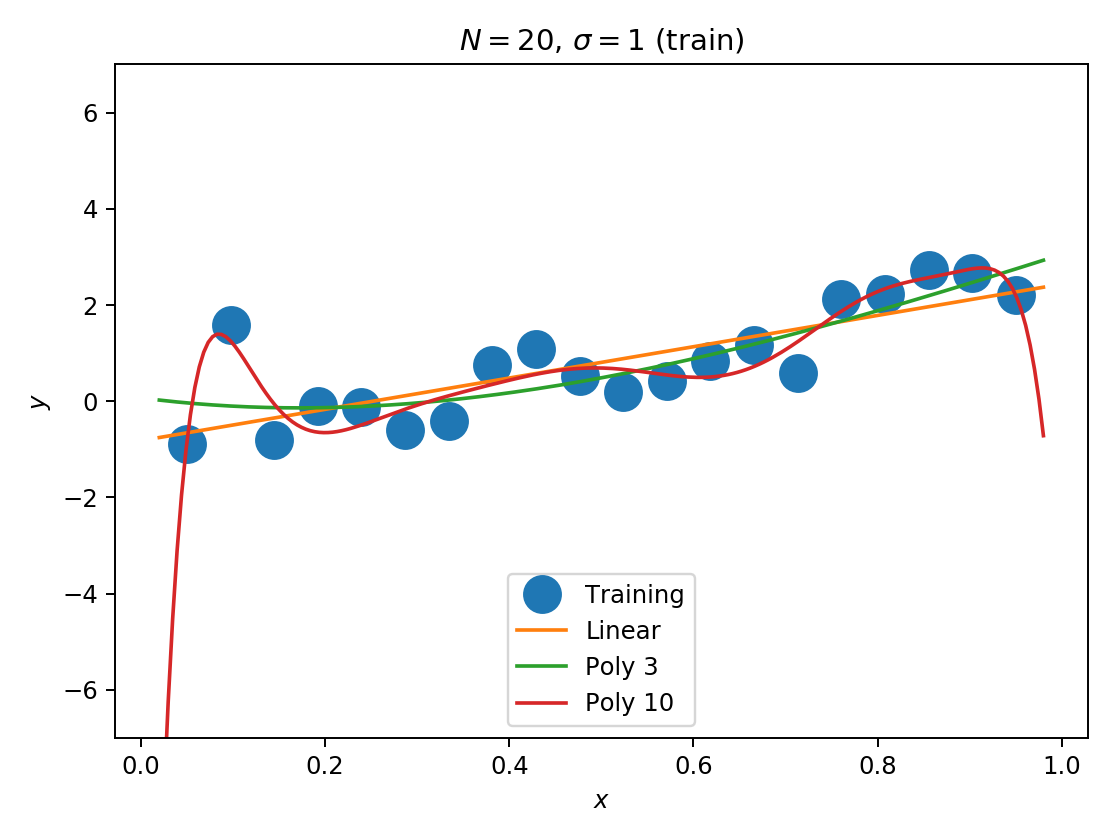

In [431]:
#This is Python Notebook to walk through polynomial regression examples
#We will use this to think about regression



import numpy as np
import sklearn as sk
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures

import matplotlib as mpl
from matplotlib import pyplot as plt
#import ml_style as sty  # optional style file, can be commented
#mpl.rcParams.update(sty.style) # optional style file, can be commented

%matplotlib notebook

# The Training Data

N_train=20

sigma_train=1;

# Train on integers
x=np.linspace(0.05,0.95,N_train)
# Draw random noise
s = sigma_train*np.random.randn(N_train)

#linear
y=2*x+s

#Tenth Order
#y=2*x-10*x**5+15*x**10+s

p1=plt.plot(x,y, "o",ms=15, label='Training')

#Linear Regression
# Create linear regression object
clf = linear_model.LinearRegression()

# Train the model using the training sets
clf.fit(x[:, np.newaxis], y)
# The coefficients

xplot=np.linspace(0.02,0.98,200)
linear_plot=plt.plot(xplot, clf.predict(xplot[:, np.newaxis]),label='Linear')

#Polynomial Regression


poly3 = PolynomialFeatures(degree=3)
X = poly3.fit_transform(x[:,np.newaxis])
clf3 = linear_model.LinearRegression()
clf3.fit(X,y)


Xplot=poly3.fit_transform(xplot[:,np.newaxis])
poly3_plot=plt.plot(xplot, clf3.predict(Xplot), label='Poly 3')



#poly5 = PolynomialFeatures(degree=5)
#X = poly5.fit_transform(x[:,np.newaxis])
#clf5 = linear_model.LinearRegression()
#clf5.fit(X,y)

#Xplot=poly5.fit_transform(xplot[:,np.newaxis])
#plt.plot(xplot, clf5.predict(Xplot), 'r--',linewidth=1)

poly10 = PolynomialFeatures(degree=10)
X = poly10.fit_transform(x[:,np.newaxis])
clf10 = linear_model.LinearRegression()
clf10.fit(X,y)

Xplot=poly10.fit_transform(xplot[:,np.newaxis])
poly10_plot=plt.plot(xplot, clf10.predict(Xplot), label='Poly 10')

axes = plt.gca()
axes.set_ylim([-7,7])

handles, labels=axes.get_legend_handles_labels()
plt.legend(handles,labels, loc='lower center')
plt.xlabel("$x$")
plt.ylabel("$y$")
Title="$N=$"+str(N_train)+", $\sigma=$"+str(sigma_train)
plt.title(Title+" (train)")
plt.tight_layout()
plt.show()

#Linear Filename
filename_train=Title+"train-linear.pdf"
#Tenth Order Filename
#filename_train=Title+"train-o10.pdf"

plt.savefig(filename_train)

<IPython.core.display.Javascript object>


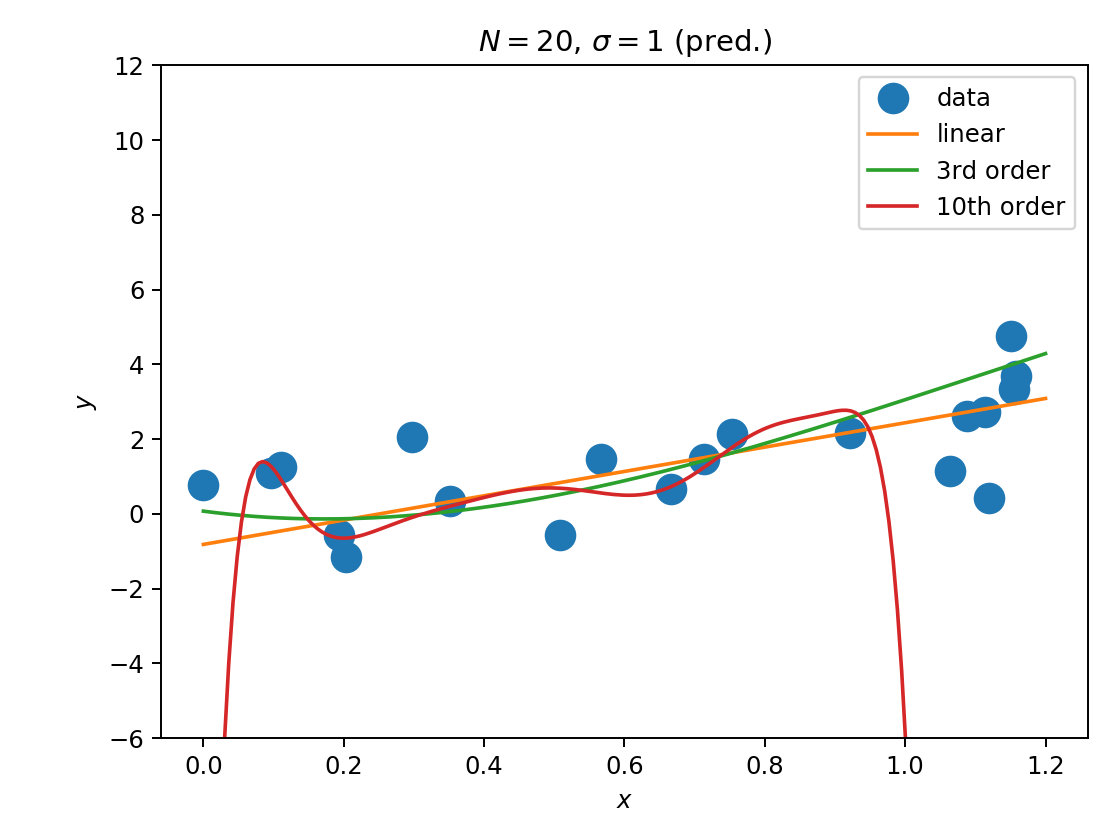

(-6, 12)

In [432]:
# Generate Test Data

#Number of test data
N_test=20

sigma_test=sigma_train

max_x=1.2
x_test=max_x*np.random.random(N_test)
# Draw random noise
s_test = sigma_test*np.random.randn(N_test)

#Linear
y_test=2*x_test+s_test
#Tenth order
#y_test=2*x_test-10*x_test**5+15*x_test**10+s_test

#Make design matrices for prediction
x_plot=np.linspace(0,max_x, 200)
X3 = poly3.fit_transform(x_plot[:,np.newaxis])
X10 = poly10.fit_transform(x_plot[:,np.newaxis])

%matplotlib notebook

fig = plt.figure() 
p1=plt.plot(x_test,y_test.transpose(), 'o', ms=12, label='data')
p2=plt.plot(x_plot,clf.predict(x_plot[:,np.newaxis]), label='linear')
p3=plt.plot(x_plot,clf3.predict(X3), label='3rd order')
p10=plt.plot(x_plot,clf10.predict(X10), label='10th order')


plt.legend(loc=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best')
plt.title(Title+" (pred.)")
plt.tight_layout()
plt.show()

#Linear Filename
filename_test=Title+"pred-linear.pdf"
#Tenth Order Filename
#filename_test=Title+"pred-o10.pdf"
plt.savefig(filename_test)
plt.ylim((-6,12))


In [398]:
#binary_convert = lambda x: [1,0] if x == 0.0 else [0,1]
#Y_data = np.array([binary_convert(_) for _ in Y_data])

In [414]:
ValidPercent = 0.8

validLimIdx = int(ValidPercent*len(X_data))

X_train = X_data[:validLimIdx,:]

Y_train = Y_data[:validLimIdx]

X_valid = X_data[validLimIdx:,:]

Y_valid = Y_data[validLimIdx:]


n = len(X_train)
assert len(X_train) == len(Y_train)
assert len(X_valid) == len(Y_valid)

print(len((X_train)),len(Y_valid))




800 200


In [422]:
def custom_accuracy(y,ypred,p01=0.0,p10=0.0,p11=1.0,p00=1.0):
    ones = tf.ones(shape=[batch_size,1],dtype=tf.int32)
    zeros = tf.zeros(shape=[batch_size,1],dtype=tf.int32)
    true_pos = tf.cast(tf.logical_and(tf.equal(y,ypred),tf.equal(ypred,ones)),tf.float32)
    false_pos = tf.cast(tf.less(y,ypred),tf.float32)
    false_neg = tf.cast(tf.less(ypred,y),tf.float32)
    true_neg = tf.cast(tf.logical_and(tf.equal(y,ypred),tf.equal(ypred,zeros)),tf.float32)
    return(p11*tf.reduce_sum(true_pos)+ p01*tf.reduce_sum(false_pos)+ \
           p10*tf.reduce_sum(false_neg)+  p00*tf.reduce_sum(true_neg))

hid_dim = 50
batch_size = 50
dim = X_train.shape[1]
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32,shape=[None,dim])
y = tf.placeholder(dtype=tf.int32,shape=[None,1])
W1 = tf.Variable(tf.truncated_normal([dim,hid_dim],stddev = 0.1),name="W1")
b1 = tf.Variable(tf.truncated_normal([hid_dim],stddev = 0.1),name="b1")
W2 = tf.Variable(tf.truncated_normal([hid_dim,2],stddev = 0.1),name="W2")
b2 = tf.Variable(tf.truncated_normal([2],stddev = 0.1),name = "b2")

z = tf.add(tf.matmul(x,W1),b1)
z = tf.sigmoid(z)
pred = tf.add(tf.matmul(z,W2),b2)
sm = tf.nn.softmax(pred)
ypred = tf.argmax(sm,axis=1,output_type=tf.int32)

total_sum = custom_accuracy(y,ypred)
ypred_inp = np.random.randint(0,2,size=[batch_size,1])
y_inp = np.random.randint(0,2,size=[batch_size,1])
# just sum up these values based on weight matrix


loss = tf.reduce_mean(sm)

global_step = tf.Variable(0, name="global_step",trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(loss,global_step)







In [424]:
sess = tf.InteractiveSession()
test_score = total_sum.eval(feed_dict={y:y_inp,ypred:ypred_inp})
print(test_score)
assert test_score == float(batch_size-np.sum(np.abs(y_inp - ypred_inp)))

init = tf.global_variables_initializer()


sess.run(init)

num_runs = n // batch_size

num_epocs = 1
k = 0
for i in range(num_runs*num_epocs):
    i = i % num_runs
    
    if i == 0 and k>0:
        num_runs_valid = X_valid.shape[0] // batch_size

        y_preds = []
        for i in range(num_runs_valid):
            batch_train = X_valid[i*batch_size:i*batch_size+batch_size]
            batch_test = Y_valid[i*batch_size:i*batch_size+batch_size] 
        #print(len(batch_train),len(batch_test))


            feed_dict = {x:batch_train,
                     y:batch_test}



            y_pred,cost = sess.run([pred,loss],feed_dict)
            y_preds.append(y_pred)
            
        output = np.sign(np.concatenate(y_preds,axis=0))
        output[output == -1] = 0
        convert_to_bin = lambda x: 0 if x[0] == 1 else 1
        output = np.array([convert_to_bin(_) for _ in output])
        yvalid = np.array([convert_to_bin(_) for _ in Y_valid])
        acc = 1 - np.mean(np.abs(yvalid - output))
        print("valid accuracy: {}".format(acc))
    
        
    else:
        batch_train = X_train[i*batch_size:i*batch_size+batch_size]
        batch_test = np.expand_dims(Y_train[i*batch_size:i*batch_size+batch_size],-1)
        #print(len(batch_train),len(batch_test))


        feed_dict = {x:batch_train,
                 y:batch_test}

        s,yhat,ysm = sess.run([total_sum,pred,idxs],feed_dict)
        print("cost: {}".format(cost))

    k = 1

ValueError: Cannot feed value of shape (50, 1) for Tensor 'ArgMax:0', which has shape '(?,)'

In [392]:
batch_test

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.]])

In [391]:
ysm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [390]:
s

0.0

In [348]:
np.argmax(ysm,axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0])

In [340]:
yhat

array([[  9.29795  ,  -9.510211 ],
       [ -2.7786052,   2.5634997],
       [ -1.5821686,   1.5616006],
       [ -3.3891635,   2.4970078],
       [ -2.1561217,   2.0966945],
       [  9.609277 , -10.344583 ],
       [ -1.9021953,   1.4326775],
       [  1.9732952,  -2.2713885],
       [ -4.0252676,   3.6448967],
       [  8.111626 ,  -8.220014 ],
       [  3.40885  ,  -4.469166 ],
       [ -3.9110277,   3.2743075],
       [ -2.646322 ,   2.6438506],
       [-11.031128 ,  10.258611 ],
       [ -2.7096245,   2.222532 ],
       [ -4.946292 ,   5.00393  ],
       [  2.2032528,  -3.4727418],
       [ -7.386797 ,   7.552315 ],
       [  1.8815472,  -2.3375356],
       [ -2.8846257,   2.8656652],
       [ -5.9442673,   5.118798 ],
       [  1.8566272,  -2.414334 ],
       [ -2.169936 ,   2.2488925],
       [ -7.896001 ,   7.0363016],
       [ -4.167549 ,   3.90387  ],
       [ -2.4136863,   1.9522889],
       [  2.9088733,  -2.8683317],
       [  2.949239 ,  -3.6528022],
       [  6.1836586,

0.6074999999999999